In [1]:
import os
import sys
import numpy as np
import networkx as nx
import itertools as it
import random as rd
import colorsys
import umap
import pickle as pk
import pymysql as mysql
from scipy.interpolate import interpn
from scipy.stats import gaussian_kde
from prettytable import PrettyTable
from fisher import pvalue
import scipy.stats as st
import scipy.cluster.hierarchy as sch
import scipy.spatial.distance as dist
from sklearn.preprocessing import normalize
from scipy.cluster.hierarchy import fcluster
from sklearn import (manifold, datasets, decomposition, ensemble,
                     discriminant_analysis, random_projection,cluster)
import os.path
import pandas as pd
from collections import (defaultdict,Counter)
import time
# import statsmodels.sandbox.stats.multicomp as mc
import matplotlib.pyplot as plt
from StyleFrame import StyleFrame, Styler
# %matplotlib inline

In [3]:

#####################################################################################
#
#         P P I  N E T W O R K
#
#    SQL STATEMENT EXECUTED IN PYTHON
#    RETURNS THE PPI AS A NETWORKX GRAPH 
#    OPTIONS:
#            - G = get_ppi(0)  CONTAINS ALL CONNECTED COMPONENTS
#            - G = get_ppi(1)  CONTAINS ONLY LCC (Largest Connected Component)
#
#    IMPLEMENTED FILTERS ARE:
#            - NO SELFLOOPS
#            - ONLY PROTEIN CODING GENES ARE INCLUDED 
#            - ONLY CONNECTIONS THAT HAVE AN AUTHOR AND PubMed ID ARE INCLUDED
#
#
####################################################################################
import pymysql as mysql




#######                                                            #######
#                                                                        #     
#                       FISHER'S EXACT TEST                              #
#                RETURNS DICT OF GO TERMS WITH P-VALUES                  #
#                                                                        #  
#######                                                            #######

def fisher_test(sig_level,sampleset,d_gene_X,d_X_gene,background,G):

    # overlap of sample genes and genes, that have a disease association
    sample_overlap = set(sampleset) & set(d_gene_X.keys())
    
    l_x = []
    for gene in sample_overlap:
        for x in d_gene_X[gene]:
            l_x.append(x)
        
    set_x = set(l_x)

    # dictionary of all terms with p-values 
    d_term_p = {}
    number_of_tests = len(set_x)
    for x in set_x:
        attributeset = set(d_X_gene[x])
        
        # take onle genes with attribures that live on G
        attribute_overlap = set(attributeset) & set(G.nodes())

        ab = len(sample_overlap.intersection(attribute_overlap))
        amb = len(sample_overlap.difference(attribute_overlap))
        bma = len(attribute_overlap.difference(sample_overlap))
        backg = background - ab - amb - bma

        p = pvalue(ab , amb, bma,backg)
        right_pval = p.right_tail
        d_term_p[x] = right_pval * number_of_tests

    return d_term_p 


#######                                                            #######
#                                                                        #     
#               TRANSLATES GENE SYMBOLS TO ENTREZ AND VV                 #
#                                                                        #  
#######                                                            #######
def genent2sym():
    d_sym_ent = {}
    d_ent_sym = {}
    
    f=open('Data/symbols2entrezIDs.txt','r')
    lines = f.readlines()#.split('\n')
    for line in lines:
        if '#' in line:
            continue
        ent = line.split('\t')
        d_sym_ent[ent[0]]=ent[1]
        d_ent_sym[ent[1]]=ent[0]
        
    f.close()
    return d_ent_sym, d_sym_ent

#########################################################################
#
#               R A N D O M   W A L K 
#
#          CALCULATES THE RANDOM WALK OPERATOR 
#             REQUIRES ADJACENCY MATRIX
#
#########################################################################


# def rnd_walk_matrix(A, r, alpha, num_nodes):
    
#     n = num_nodes
#     M = normalize(A, norm='l1', axis=0)                                 # column wise normalized MArkov matrix
#     factor = float((1-alpha)/n)
# #     print(factor)
#     E = np.multiply(factor,np.ones([n,n]))              # prepare 2nd scaling term
#     M2 = np.multiply(alpha,M) + E                                       # mixture of Markov chains
#     del M
#     del E
    
#     U = np.identity(n,dtype=int) 
#     H = (1-r)*M2
#     H1 = np.subtract(U,H)
#     del U
#     del M2
#     del H    

#     W = r*np.linalg.inv(H1)                                             # calculate random-walk matrix
#     del H1
#     return W


def rnd_walk_matrix2(A, r, a, num_nodes):

    num = 1*num_nodes
    n = num_nodes
    factor = float((1-a)/n)

    E = np.multiply(factor,np.ones([n,n]))              # prepare 2nd scaling term
    A_tele = np.multiply(a,A) + E  

#     print(A_tele)
    M = normalize(A_tele, norm='l1', axis=0)                                 # column wise normalized MArkov matrix

    # mixture of Markov chains
    del A_tele
    del E

    U = np.identity(n,dtype=int) 
    H = (1-r)*M
    H1 = np.subtract(U,H)
    del U
    del M
    del H    

    W = r*np.linalg.inv(H1)   

    return W




#########################################################################
#
#               G E N E   O N T O L O G Y
#
#          GENERATES DISEASE ONTOLOGY TREE GRAPH
#
#########################################################################


def GO_tree(branch_category,graphtype,stream = 'up'):

    

    if stream == 'up':
        if branch_category == 'cell':
            G=pk.load(open('Data/G_GOcell_up.pkl', 'rb')) 
        if branch_category == 'mol':
            G=pk.load(open('Data/G_GOmol_up.pkl', 'rb')) 
        if branch_category == 'bio':
            G=pk.load(open('Data/G_GObio_up.pkl', 'rb'))   

    if stream == 'down':
        # down
        if branch_category=='cell':
            G=pk.load(open('Data/G_GOcell_down.pkl','rb'))
        if branch_category == 'mol':
            G=pk.load(open('Data/G_GOmol_down.pkl', 'rb'))
        if branch_category == 'bio':
            G=pk.load(open('Data/G_GObio_down.pkl', 'rb'))   
            
    if stream == 'un':
        # down
        if branch_category=='cell':
            G=pk.load(open('Data/G_GOcell_un.pkl','rb'))
        if branch_category == 'mol':
            G=pk.load(open('Data/G_GOmol_un.pkl', 'rb'))
        if branch_category == 'bio':
            G=pk.load(open('Data/G_GObio_un.pkl', 'rb'))  
                                        
    if branch_category == 'cell':
        # 'cellular_component':'GO:0005575'
        tip = 'GO:0005575'
    if branch_category == 'mol':
        # 'molecular_function':'GO:0003674'  
        tip = 'GO:0003674'
    if branch_category == 'bio':
        # 'biological_process':'GO:0008150'  
        tip = 'GO:0008150'
    G.add_node(tip)
    
    
    return G, tip


"""
function gets GO branch as input
returns dictionary gene: go_list (upstream included)
and go: gene_list
categories: cell, mol, bio
"""
def gene2go(branch_category):
    
    if branch_category == 'cell':
        d_gene_go = pk.load(open('Data/d_genes_gocell.pkl', 'rb')) 
        d_go_gene = pk.load(open('Data/d_gocell_genes.pkl', 'rb')) 
        
    if branch_category == 'mol':
        d_gene_go = pk.load(open('Data/d_genes_gomol.pkl', 'rb'))
        d_go_gene = pk.load(open('Data/d_gomol_genes.pkl', 'rb'))
        
    if branch_category == 'bio':
        d_gene_go = pk.load(open('Data/d_genes_gobio.pkl', 'rb'))
        d_go_gene = pk.load(open('Data/d_gobio_genes.pkl', 'rb'))
    
    return d_gene_go, d_go_gene

"""

function gets list of GO term-IDs as input 
and returns a dictionary of keys: GO-IDs values: GO-names

"""

def GOnames(category = 'cell'):
    
    if category == 'bio':
        d_go_id_name = pk.load(open('Data/d_gobio_name.pkl', 'rb'))
        
    elif category == 'mol':
        d_go_id_name = pk.load(open('Data/d_gomol_name.pkl', 'rb'))
        
    else:
        d_go_id_name = pk.load(open('Data/d_gocell_name.pkl', 'rb'))
        

    
    return d_go_id_name

#########################################################################
#########################################################################




##########################################################################################
#
#  function gets an integer number
#  and returns n HEX colors that are most distinct to each other 
#
##########################################################################################

def color_creator(n):

    colors = [colorsys.hsv_to_rgb(1.0/n*x,1,1) for x in range(n)]
    color_list = []
    for c in colors:
        cc = [int(y*255) for y in c]
        color_list.append('#%02x%02x%02x' % (cc[0],cc[1],cc[2]))
        
    return color_list

##########################################################################################
#
#  function gets an integer number
#  and returns n/4 HEX colors that are most distinct to each other 
#  plus their 3 corresponding color values for 60% saturation and/or 
#  60% light-level
#
##########################################################################################

def color_creator_more(n):
    k = n%4
    m = int(((n+4)-k)/4)
    colors_1 = [colorsys.hsv_to_rgb(1.0/m*x,1,1) for x in range(m)]
    colors_2 = [colorsys.hsv_to_rgb(1.0/m*x,.6,1) for x in range(m)]
    colors_3 = [colorsys.hsv_to_rgb(1.0/m*x,1,.6) for x in range(m)]
    colors_4 = [colorsys.hsv_to_rgb(1.0/m*x,.6,.6) for x in range(m)]


    colors = colors_1 + colors_2 +  colors_3 + colors_4
    color_list = []
    for c in colors:
        cc = [int(y*255) for y in c]
        color_list.append('#%02x%02x%02x' % (cc[0],cc[1],cc[2]))
#     for c in colors_2:
#         cc = [int(y*255) for y in c]
#         color_list.append('#%02x%02x%02x' % (cc[0],cc[1],cc[2]))
    return color_list

###############################################
#                                             #
#  IDENTIFY THE MOST FITTING TERM             #
#  TO NAME A CLUSTER                          #
#  TAKE TERM OF MAXIMAL FREQUENCY AND SELECT  #
#  THE MOST SPECIFIC AMONG THEM               #
#                                             #
###############################################

def most_informative_label(G_tree, tree_tip,List,n): 
#     overlap_set = set(d_updo_geneset[t]) & set(List)
    list1 = [ elem for elem in List if elem != tree_tip] 


    occurence_count = Counter(list1) 
    d_term_freq = occurence_count.most_common(n)
    max_f = d_term_freq[0][1]
#     print(d_term_freq)
    # Get all term with maximal frequency
    l_pot_terms = []
    for term, freq in d_term_freq:
        if freq < max_f:
            break
        else:
            l_pot_terms.append(term)
#     print(l_pot_terms)        
    # pick term with highest specificity (max dist to tree tip) 
    taken_spec = 2
    taken_term = []
#     for term in l_pot_terms:
    for term_f in d_term_freq:
        term = term_f[0]
        specificity =  nx.shortest_path_length(G_tree,term,tree_tip)
        if specificity > taken_spec:
            taken_spec = specificity
            taken_term.append(term)
        elif specificity > taken_spec+1:
            taken_term.append(term)
        else:
            pass
        
    return taken_term

# LOAD NETWORK AND GENE ANNOTATIONS

In [4]:
t0 = time.time()

# read in the subnetwork that want to work with (after expansion)
G = nx.read_edgelist('mydata/AutoCore.elist')
d_ent_sym, d_sym_ent = genent2sym()


# gene ontology
go_branch = 'cell'
d_gene_gocell, d_gocell_gene = gene2go(go_branch)
G_GOcell_up, celltip = GO_tree(go_branch,'directed',stream = 'up')
G_GOcell_down, celltip = GO_tree(go_branch,'directed',stream = 'down')
G_GOcell_un, celltip = GO_tree(go_branch,'undirected',stream = 'un')
d_gocell_name = GOnames(category = 'cell')


go_branch = 'mol'
d_gene_gomol, d_gomol_gene = gene2go(go_branch)
G_GOmol_up, moltip = GO_tree(go_branch,'directed',stream = 'up')
G_GOmol_down, moltip = GO_tree(go_branch,'directed',stream = 'down')
G_GOmol_un, moltip = GO_tree(go_branch,'undirected',stream = 'un')
d_gomol_name = GOnames(category = 'mol')

go_branch = 'bio'
d_gene_gobio, d_gobio_gene = gene2go(go_branch)
G_GObio_up, biotip = GO_tree(go_branch,'directed',stream = 'up')
G_GObio_down, biotip = GO_tree(go_branch,'directed',stream = 'down')
G_GObio_un, biotip = GO_tree(go_branch,'undirected',stream = 'un')
d_gobio_name = GOnames(category = 'bio')



print('CPU time for getting and processing annotations: %.2f (sec)' %float(time.time()-t0))

CPU time for getting and processing annotations: 1.75 (sec)


In [5]:
# chose annotation:

d_gene_term = {}

set_GOgenes = set(d_gene_gocell.keys()) | set(d_gene_gomol.keys()) | set(d_gene_gobio.keys())
for gene in set_GOgenes:
    try:
        cell = d_gene_gocell[gene]
    except:
        cell = []
    try:
        mol = d_gene_gomol[gene]
    except:
        mol = []
    try:
        bio = d_gene_gobio[gene]
    except:
        bio = []        
    d_gene_term[gene] = set(cell + mol + bio)
        
        
d_term_gene = {}

set_GOterms = set(d_gobio_gene.keys()) | set(d_gomol_gene.keys()) | set(d_gocell_gene.keys())
for term in set_GOterms:
    try:
        cell = d_gocell_gene[term]
    except:
        cell = []
    try:
        mol = d_gomol_gene[term]
    except:
        mol = []
    try:
        bio = d_gobio_gene[term]
    except:
        bio = []        
    d_term_gene[term] = set(cell + mol + bio)
    
    
#merging name dictionaries

namedict = {**d_gobio_name , **d_gomol_name}
d_names={**namedict,**d_gocell_name }


In [7]:
#
#
# Here one can specify file names for saving
# 
#

# cluster picture 
umap_picture = 'mydata/UMAP_picture.pdf' 
cluster_picture = 'mydata/UMAP_clusters_AutoCore.pdf' 
picture_with_labels='mydata/UMAP_clusters_labeled_AutoCore.pdf'
# cluster histogram
hist_pic = 'mydata/AutoCore_clusters_hist.pdf'
# summary file name
summary_file="mydata/AutoCore_clusters_summary.tsv"
# gene file name 
clustergenes='mydata/AutoCore_cluster_genes.txt'
# annotation 
writer = StyleFrame.ExcelWriter('mydata/AutoCore_GO_annotation.xlsx')


# SEED GENE SETS

In [8]:
f = open('mydata/mono_AIM_AIF_IDs.txt','r')
lines = f.readlines()
f.close()
mono_all = lines[0].split('\n')[0].split('\t')[1:-1]


# RUN RANDOM WALK -> DEFINE NEIGHBORHOOD

In [9]:
t0 = time.time()

#################################################################
#
#    GET LCC PPI HERE AND GENERATE ADJACENCY MATRIX
#
###################
#   
#    PARAMETERS

r = .9
alpha = 1.

###################


# G = nx.erdos_renyi_graph(200,.1) # test with random matrix
num_nodes = G.number_of_nodes()
A = nx.adjacency_matrix(G,sorted(G.nodes()))


#################################################################
#
#    INVERT MARKOV MATRIX & GENERATE RW MATRIX
#
###################

W = rnd_walk_matrix2(A, r, alpha, num_nodes)

print('Inversion done')

#################################################################
#
#    GENERATE DICT FOR NODE-LABELS TO INTEGERS
#
###################

d_idx_entz = {}
cc = 0
for entz in sorted(G.nodes()):
    d_idx_entz[cc] = entz
    cc += 1
d_entz_idx = dict((y,x) for x,y in d_idx_entz.items())   


print('computing time - random walk: %.2f (sec)' %float(time.time()-t0))

Inversion done
computing time - random walk: 0.05 (sec)


In [10]:
########################################################################
#
#    CREATE NEIGHBORHOOD FILE FOR EACH NODE
#    FOR ANY NEIGHBOR THAT IS REACHED BY coverage% OF VISIT PROBABILITY
#
###################

t0 = time.time()

coverage = .95
d_node_neighbors = {}
for node in G.nodes():
    node_idx = d_entz_idx[node]   
    df = pd.DataFrame(np.array(W[:,node_idx]))

    s = df.sort_values(by = 0 ,ascending = False).values
    cums = s.cumsum(0)
    n = 0
    for x in cums:
        if x[0] < coverage:
            n += 1
        else:
            thresh = s[n][0]
            break

    # loop through (unsorted) probability vector
    l_neighnodes = []
    for m in range(num_nodes):
        prb = df.get_value(m,0)
        if prb > thresh:
            l_neighnodes.append(d_idx_entz[m])
            
#     l_neighnodes2 = l_neighnodes.remove(node)
    d_node_neighbors[node] = l_neighnodes


print('time to generate neighborhood file: %.2f (sec)' %float(time.time()-t0))

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: FutureWarning:get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: FutureWarning:get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: FutureWarning:get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: FutureWarning:get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: FutureWarning:get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/anaconda3/lib/python3.7/site-packages/ipykernel_launch

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: FutureWarning:get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: FutureWarning:get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: FutureWarning:get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: FutureWarning:get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: FutureWarning:get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/anaconda3/lib/python3.7/site-packages/ipykernel_launch

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: FutureWarning:get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: FutureWarning:get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: FutureWarning:get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: FutureWarning:get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: FutureWarning:get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/anaconda3/lib/python3.7/site-packages/ipykernel_launch

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: FutureWarning:get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: FutureWarning:get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: FutureWarning:get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: FutureWarning:get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: FutureWarning:get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/anaconda3/lib/python3.7/site-packages/ipykernel_launch

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: FutureWarning:get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: FutureWarning:get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: FutureWarning:get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: FutureWarning:get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: FutureWarning:get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/anaconda3/lib/python3.7/site-packages/ipykernel_launch

time to generate neighborhood file: 1.69 (sec)


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: FutureWarning:get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: FutureWarning:get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: FutureWarning:get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: FutureWarning:get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: FutureWarning:get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/anaconda3/lib/python3.7/site-packages/ipykernel_launch

# ENRICHMENT

In [11]:
t0 = time.time()
sig_level = .05

background = len(set(d_gene_term.keys()) & set(G.nodes()))
print('Number of background genes: %s' %background)

# fdis = open('enrich_dis_result.txt','w')

t0 = time.time()
c = 0
d_gene_enrterms_pval = {} 
d_gene_enrterms = {} 


for gene, l_terms in d_node_neighbors.items():

    c += 1
    sampleset = set(l_terms)

    d_term_p = fisher_test(sig_level,sampleset,d_gene_term,d_term_gene,background,G)

    l_enrichedterms_pval = []
    l_enrichedterms = []
    for x in d_term_p.items():
        if (x[1] < sig_level):
            l_enrichedterms_pval.append((x[0],x[1]))
            l_enrichedterms.append(x[0])



    d_gene_enrterms_pval[gene] = l_enrichedterms_pval
    d_gene_enrterms[gene] = l_enrichedterms

        


print('time for fishers test: %.3f (sec)' %(time.time()-t0))



Number of background genes: 387
time for fishers test: 49.411 (sec)


In [13]:
# ADD ENRICHED TERMS TO PLAIN  
d_gene_terms_all = {}
for gene in G.nodes():
        
    try:
        l_enr = d_gene_enrterms[gene]
    except KeyError:
        l_enr = []    
    
    try:
        l_pure = d_gene_term[gene]
    except KeyError:
        l_pure = []
        
        
    s_all = set(list(l_enr)+list(l_pure))
    if len(s_all) > 0:
        d_gene_terms_all[gene] = s_all


d_gene_idx_feat = {}
d_idx_gene_feat = {}
nn = 0      
        

l_terms = []

for gene, l_t in sorted(d_gene_terms_all.items()):
    l_terms += l_t 
    d_gene_idx_feat[gene] = nn
    d_idx_gene_feat[nn] = gene
    nn += 1   
    
s_terms = set(l_terms)

In [14]:
print(G.number_of_nodes())
print(len(d_gene_terms_all.keys()))


399
393


# FEATURE MATRIX

In [15]:
# Create a feature matrix having as row indices the genes sorted by d_gene_idx keys
# and features (annotations) as columns ordered like the set of annotation terms


# can define my own feature matrix - > can read in an FX


t0 = time.time()


d_t_idx = {}
c = 0
for t in sorted(s_terms):
    d_t_idx[t] = c
    c += 1

# initialize feature matrix here

# size (#rows,#cols)
size_featureMat = (len(d_gene_terms_all.keys()),len(s_terms))
FX = np.zeros(size_featureMat) # here the empty feature matrix is defined

# iterating through rows (genes)
c = 0
for row in FX:
    gene = d_idx_gene_feat[c]
    for t in d_gene_terms_all[gene]:
        row[d_t_idx[t]]=1
    c += 1
        

n_samples, n_features = FX.shape
print('number of features/annotations (columns): %s' %n_features)
print('number of samples/genes (rows): %s' %n_samples)

print('CPU time %s' %(time.time()-t0))



number of features/annotations (columns): 7272
number of samples/genes (rows): 393
CPU time 0.057415008544921875


# t-SNE

In [16]:

t0 = time.time()

prplxty = 30 # default = 30.
density = 10. # default 12.
l_rate = 100. # default 200.

tsne = manifold.TSNE(n_components=2, init='pca', random_state=0, perplexity = prplxty, 
                     early_exaggeration = density,  learning_rate = l_rate)#,n_iter = 250)

X_tsne2D = tsne.fit_transform(FX)
print('tsne time.time(): %f ' %  (time.time()-t0))

# tsne = manifold.TSNE(n_components=3, init='pca', random_state=0, perplexity = prplxty, 
#                      early_exaggeration = density,  learning_rate = l_rate)
# X_tsne3D = tsne.fit_transform(FX)
# print('time.time(): %f ' %  (time.time()-t0))




tsne time.time(): 6.069658 


# t-SNE NETWORK PICTURE 

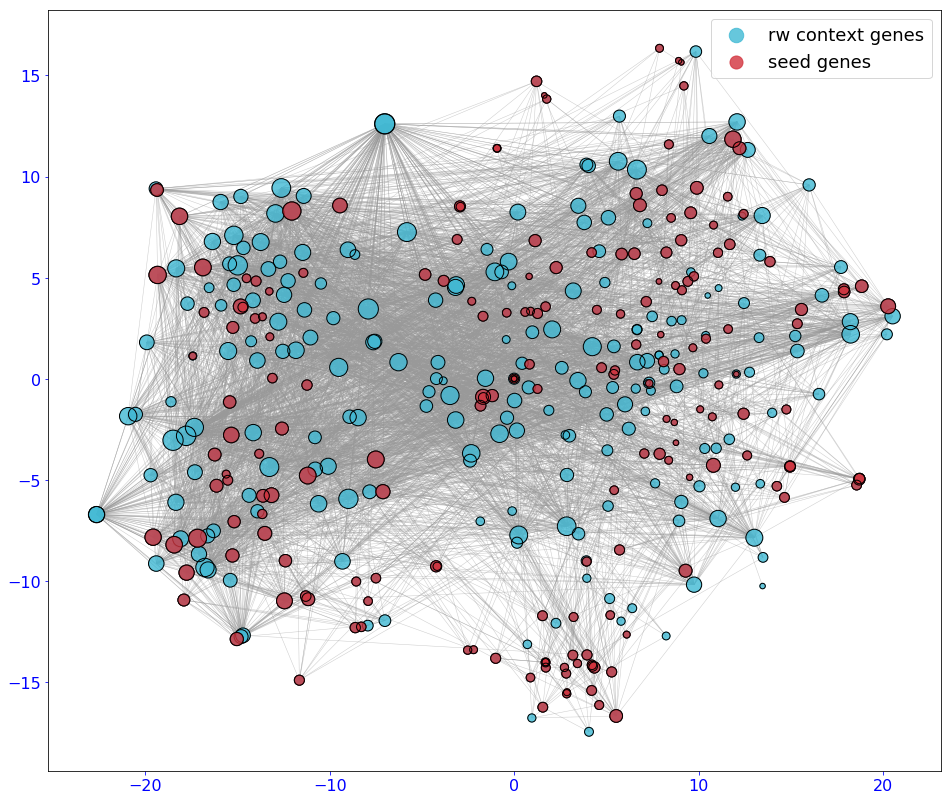

In [19]:
# position for nodes without any functional features
posG = {}
for node in sorted(d_gene_terms_all.keys()):
    n_index = d_gene_idx_feat[node]
    xpos = X_tsne2D[n_index,0]
    ypos = X_tsne2D[n_index,1]
    posG[node] = (xpos,ypos)
    
# position for nodes without any functional features
nodes_no_feat = set(G.nodes())-set(d_gene_terms_all.keys())
for node in nodes_no_feat:
#     print(node)
    posG[node] = (0.,0.)



plt.figure(figsize=(16,14))

edgewidth = .5#[ .2*d['weight'] for (u,v,d) in G_result.edges(data=True)]

# nx.draw_networkx_labels(G_map,pos=posG,with_labels = 1,labels=d_cid_label,node_size = 1,font_size=20)
nx.draw_networkx_edges(G, pos=posG, width=edgewidth,edge_color='#999999',alpha=.5)

scalef = 15
x = 20
power = .7
# ring_frac = np.sqrt((x-1.)/x)
ring_frac = (x-1.)/x

l_x = []
l_y = []
l_size_outer = []
l_size_inner = []
for node in G.nodes():

    k = nx.degree(G,node)
    R = scalef*(1+k**power)
    r = ring_frac * R
    l_size_outer.append(R)
    l_size_inner.append(r)
    l_x.append(posG[node][0])
    l_y.append(posG[node][1])


plt.scatter(l_x,l_y,s=l_size_inner,c = '#40b9d4',label = 'rw context genes',zorder=2,alpha=.8)
plt.scatter(l_x,l_y,s=l_size_outer,facecolors='none',edgecolors='k',zorder=2)

l_x = []
l_y = []
l_size_outer = []
l_size_inner = []
for node in G.nodes():
    if node in mono_all:

        k = nx.degree(G,node)
        R = scalef*(1+k**power)
        r = ring_frac * R
        l_size_outer.append(R)
        l_size_inner.append(r)
        l_x.append(posG[node][0])
        l_y.append(posG[node][1])


plt.scatter(l_x,l_y,s=l_size_inner,c = '#d2323c',label = 'seed genes',zorder=2,alpha=.8)
plt.scatter(l_x,l_y,s=l_size_outer,facecolors='none',edgecolors='k',zorder=2)



plt.legend(fontsize=18)

    
ax = plt.gca()

# ax.set_xticks(range(len(l_r)))    
# ax.set_xticklabels(x_ticks, rotation=90) #set the labels and rotate them 90 deg.
tick_color = 'b'
plt.tick_params(axis='both', which='major', colors=tick_color,labelsize=16)
ax.xaxis.label.set_color(tick_color)
ax.yaxis.label.set_color(tick_color)  



In [20]:

t0 = time.time()

n_neighs = 10
mind = 4
spread = 8.


reducer = umap.UMAP(n_components=2,n_neighbors=n_neighs, metric = 'cosine', min_dist=mind, spread = spread)
umap_pos = reducer.fit_transform(FX)

print('UMAP time : %f ' %  (time.time()-t0))

/Users/jpazmandi/.local/lib/python3.7/site-packages/umap/umap_.py:1158: RuntimeWarning:divide by zero encountered in power
/Users/jpazmandi/.local/lib/python3.7/site-packages/numba/np/ufunc/parallel.py:355: NumbaWarning:The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 11000. The TBB threading layer is disabled.


UMAP time : 12.603911 


# OPTIONAL PREVIEW 

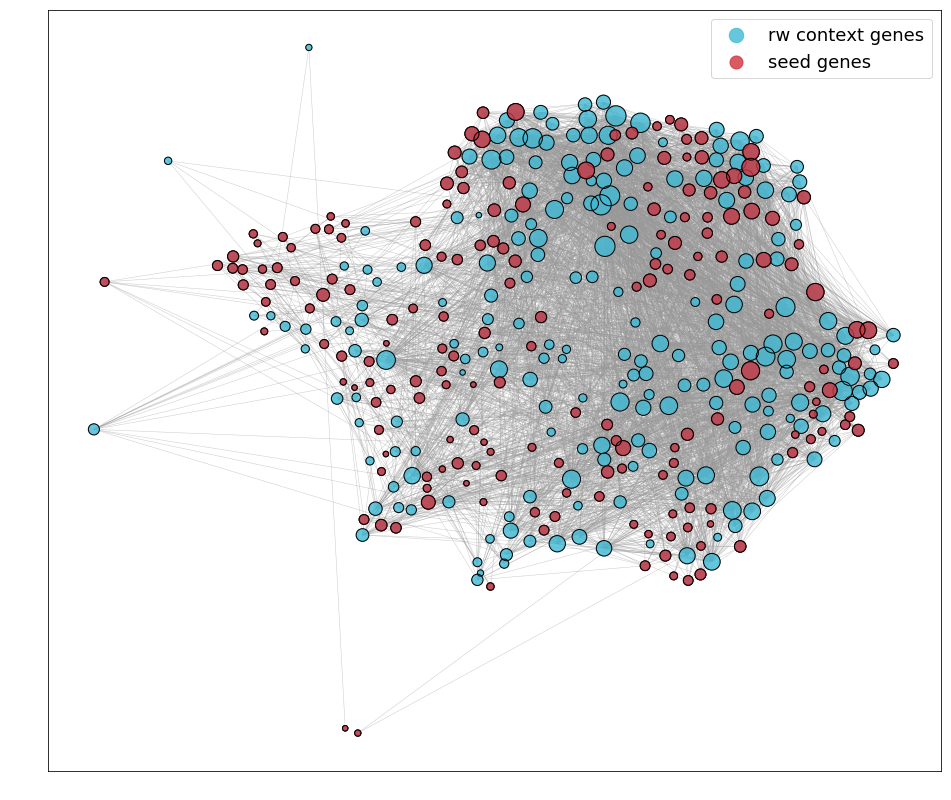

In [23]:
# position for nodes without any functional features
posG = {}
for node in sorted(d_gene_terms_all.keys()):
    n_index = d_gene_idx_feat[node]
    xpos = umap_pos[n_index,0]
    ypos = umap_pos[n_index,1]
    posG[node] = (xpos,ypos)
    
# position for nodes without any functional features
nodes_no_feat = set(G.nodes())-set(d_gene_terms_all.keys())

# HALO for no-features genes
l_radii = [x*x+y*y for x,y in list(posG.values())]
radius = 1.15*np.sqrt(max(l_radii))
x0 = 0
y0 = 0
for g in nodes_no_feat:
    phi =  rd.uniform(-np.pi, np.pi)
#     theta = rd.uniform(0, np.pi)
    x = radius * np.cos(phi) + x0
    y = radius * np.sin(phi) + y0
    posG[g] = (x,y)




plt.figure(figsize=(16,14))

edgewidth = .5#[ .2*d['weight'] for (u,v,d) in G_result.edges(data=True)]

# nx.draw_networkx_labels(G_map,pos=posG,with_labels = 1,labels=d_cid_label,node_size = 1,font_size=20)
nx.draw_networkx_edges(G, pos=posG, width=edgewidth,edge_color='#999999',alpha=.5)

scalef = 15
x = 20
power = .7
# ring_frac = np.sqrt((x-1.)/x)
ring_frac = (x-1.)/x

l_x = []
l_y = []
l_size_outer = []
l_size_inner = []
for node in G.nodes():

    k = nx.degree(G,node)
    R = scalef*(1+k**power)
    r = ring_frac * R
    l_size_outer.append(R)
    l_size_inner.append(r)
    l_x.append(posG[node][0])
    l_y.append(posG[node][1])


plt.scatter(l_x,l_y,s=l_size_inner,c = '#40b9d4',label = 'rw context genes',zorder=2,alpha=.8)
plt.scatter(l_x,l_y,s=l_size_outer,facecolors='none',edgecolors='k',zorder=2)

l_x = []
l_y = []
l_size_outer = []
l_size_inner = []
for node in G.nodes():
    if node in mono_all:

        k = nx.degree(G,node)
        R = scalef*(1+k**power)
        r = ring_frac * R
        l_size_outer.append(R)
        l_size_inner.append(r)
        l_x.append(posG[node][0])
        l_y.append(posG[node][1])


plt.scatter(l_x,l_y,s=l_size_inner,c = '#d2323c',label = 'seed genes',zorder=2,alpha=.8)
plt.scatter(l_x,l_y,s=l_size_outer,facecolors='none',edgecolors='k',zorder=2)



plt.legend(fontsize=18)

    
ax = plt.gca()


tick_color = 'w'
plt.tick_params(axis='both', which='major', colors=tick_color,labelsize=16)
ax.xaxis.label.set_color(tick_color)
ax.yaxis.label.set_color(tick_color)  


# GENE 2 GENE MATRIX & LINKAGE

In [24]:
t0 = time.time()

# metric = 'euclidean'
metric = 'cosine' # can change the metric
# USE package to here, much faster!
D = dist.pdist(FX,metric = metric)

L = sch.linkage(D, method = 'complete',metric = metric) # can change the clustering method


print('time.time(): %f' % (time.time()-t0))

time.time(): 0.734008


80


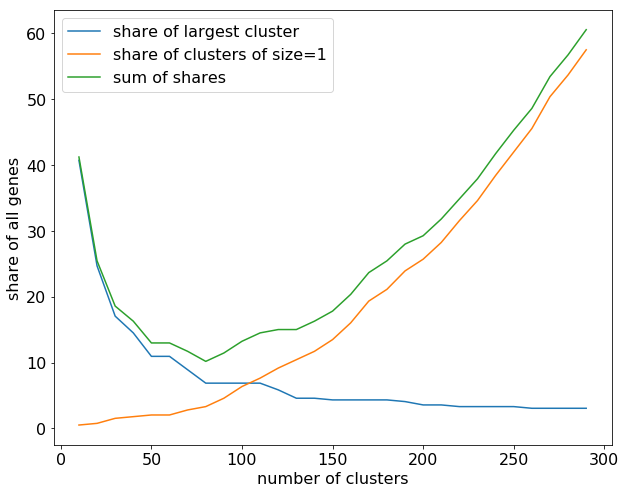

In [25]:
# EVALUATE OPTIMAL CLUSTER NUMBER
cs_range = range(10,300,10)
l_frac_bigvs1 = []
l_frac_big = []
l_frac_s1 = []
for max_num_clusters in cs_range:
    l_cluster = fcluster(L, max_num_clusters, criterion='maxclust')
    # size of clusters
    d_c_s = {}
    for cl in set(l_cluster):
        d_c_s[cl] =  list(l_cluster).count(cl)

    for a,b in sorted(d_c_s.items(), key = lambda x: x[1], reverse = True)[:1]:
        max_size = b
        max_size_frac = 100.*b/n_samples
#         print('size of largest cluster: %s (cov = %.0f%%)' %(max_size,max_size_frac))

    c_1_number = list(d_c_s.values()).count(1)
    c_1_number_frac = 100.*c_1_number/n_samples
    l_frac_big.append(max_size_frac)
    l_frac_s1.append(c_1_number_frac)
    l_frac_bigvs1.append(max_size_frac+c_1_number_frac)

index_min = np.argmin(np.array(l_frac_bigvs1))
#     print(index_min)
min_cs = cs_range[index_min]

print(min_cs)        


# min_cs = 1450

plt.figure(figsize=(10,8))


# plt.bar(range(len(d_c_s.keys()))[:40],sorted(d_c_s.values(),reverse = True)[:40])    
plt.plot(cs_range,l_frac_big,label='share of largest cluster')
plt.plot(cs_range,l_frac_s1, label = 'share of clusters of size=1')
plt.plot(cs_range,l_frac_bigvs1,label='sum of shares')

plt.legend(fontsize =16)
plt.xlabel('number of clusters',fontsize =16)
plt.ylabel('share of all genes',fontsize =16)

ax = plt.gca()
tick_color = 'k'
plt.tick_params(axis='both', which='major', colors=tick_color,labelsize=16)
ax.xaxis.label.set_color(tick_color)
ax.yaxis.label.set_color(tick_color)



In [26]:
L[L<0.0] = 0.0


max_num_clusters = 25 #min_cs
l_cluster = fcluster(L, max_num_clusters, criterion='maxclust')
print('number of clusters: %s' %len(set(l_cluster)))



d_c_s = {}
for cl in set(l_cluster):
    d_c_s[cl] =  list(l_cluster).count(cl)

d_cluster_geneset = defaultdict(list)
node_idx = 0
for cluster_id in l_cluster:
    gene = d_idx_gene_feat[node_idx]
    node_idx += 1
    for cl in set(l_cluster):
        if cl == cluster_id:
            d_cluster_geneset[cl].append(gene)

number of clusters: 25


# CLUSTER COLORS ON LAYOUT

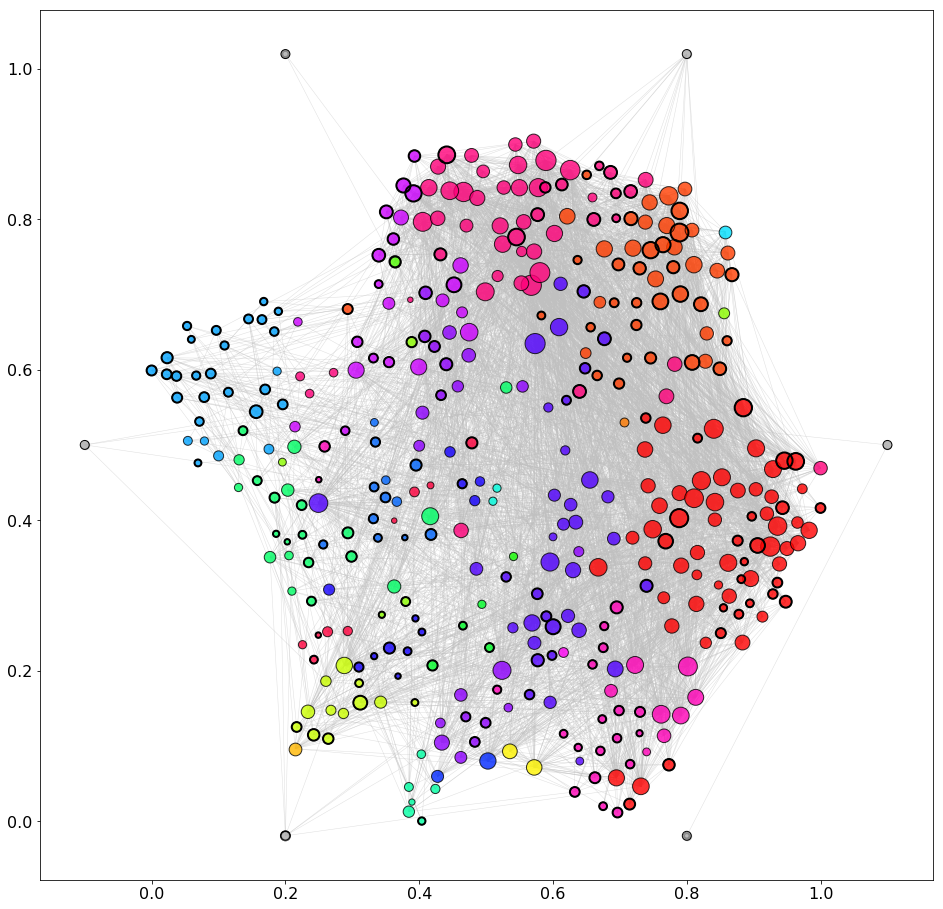

In [29]:
l_col = color_creator(len(set(l_cluster)))
rd.shuffle(l_col)
# l_col = cemm_pal(len(set(l_cluster)))
d_cl_col = {}
c = 0
for cl,size in sorted(d_c_s.items(), key = lambda x: x[1], reverse = True):
    if cl == 0:
        d_cl_col[cl] = '#ababab'
    else:
        d_cl_col[cl] = l_col[c]
    c +=1


# # NORMALIZE COORDINATES
# l_x = X_tsne2D[:,0]
# l_y = X_tsne2D[:,1]

# NORMALIZE COORDINATES
l_x = umap_pos[:,0]
l_y = umap_pos[:,1]

x_min = min(l_x)
x_max = max(l_x)
y_min = min(l_y)
y_max = max(l_x)

l_xn = [(x-x_min)/(x_max-x_min) for x in l_x]
l_yn = [(y-y_min)/(y_max-y_min) for y in l_y]


posG = {}
for gene in d_gene_terms_all.keys():
    idx = d_gene_idx_feat[gene]
    posG[gene] = (l_xn[idx],l_yn[idx])

# position for nodes without any functional features
# for node in nodes_no_feat:
#     posG[node] = (0.,0.)

# CREATE HALO OUT OF NON-ANNOTATED GENES:
# SET OF NON-ANNOTATED GENES:
nodes_no_feat = set(G.nodes())-set(d_gene_terms_all.keys())
# divide 360 by this number to get angle increments
deg_i = 2.*np.pi / len(nodes_no_feat)
l_xno = []
l_yno = []
x0 = min(l_xn)+.5
y0 = min(l_yn)+.5
if (max(l_xn)-min(l_xn)) > (max(l_yn)-min(l_yn)):
    radius = .6*(max(l_xn)-min(l_xn))
else:
    radius = .6*(max(l_yn)-min(l_yn))

for g in range(len(nodes_no_feat)):
    x = radius*np.cos(g*deg_i) + x0
    y = radius*np.sin(g*deg_i) + y0
    l_xno.append(x)
    l_yno.append(y)    
    
scalef = 15
x = 20
power = .7
# ring_frac = np.sqrt((x-1.)/x)
ring_frac = (x-1.)/x

n_none = 0
for node in nodes_no_feat:
    posG[node] = (l_xno[n_none],l_yno[n_none])
    n_none += 1
    
    
plt.figure(figsize=(16,16))


plt.scatter(l_xno,l_yno,s=70,c = '#ababab',label = 'none:',zorder=2,alpha=.8)
plt.scatter(l_xno,l_yno,s=80,facecolors='none',edgecolors='k',zorder=2)


edgewidth = .5#[ .2*d['weight'] for (u,v,d) in G_result.edges(data=True)]

# nx.draw_networkx_labels(G_map,pos=posG,with_labels = 1,labels=d_cid_label,node_size = 1,font_size=20)
nx.draw_networkx_edges(G, pos=posG, width=edgewidth,edge_color='#C0C0C0',alpha=.5)

scalef = 15
power = .7

for cluster, geneset in d_cluster_geneset.items():
    color = d_cl_col[cluster]
    l_x = []
    l_y = []
    l_size_outer = []
#     l_size_inner = []
    for node in G.nodes():
        if node in geneset:
            k = nx.degree(G,node)
            R = scalef*(1+k**power)
#             r = ring_frac * R
            l_size_outer.append(R)
#             l_size_inner.append(r)
            l_x.append(posG[node][0])
            l_y.append(posG[node][1])


    plt.scatter(l_x,l_y,s=l_size_outer,c = color,label = '%s' %cluster,alpha=.8,edgecolors='k',linewidths=1)
#     plt.scatter(l_x,l_y,s=l_size_outer,facecolors='none',edgecolors='k',linewidths=5,zorder=2)

  
l_x = []
l_y = []
l_size_outer = []
for node in G.nodes():
    if node in mono_all:

        k = nx.degree(G,node)
        R = scalef*(1+k**power)
        r = ring_frac * R
        l_size_outer.append(R)
        l_x.append(posG[node][0])
        l_y.append(posG[node][1])


plt.scatter(l_x,l_y,s=l_size_outer,facecolors='none',edgecolors='k',linewidths=2,label = 'seed genes')


    
ax = plt.gca()

# ax.set_xticks(range(len(l_r)))    
# ax.set_xticklabels(x_ticks, rotation=90) #set the labels and rotate them 90 deg.
tick_color = 'black'
plt.tick_params(axis='both', which='major', colors=tick_color,labelsize=16)
ax.xaxis.label.set_color(tick_color)
ax.yaxis.label.set_color(tick_color)  
plt.savefig(cluster_picture)





# CHARACTERIZATION

largest cluster contains 67 genes.
there are 6 clusters of size 1
there are 10 clusters of size smaller than 5
there are 12 clusters bigger than 10 genes


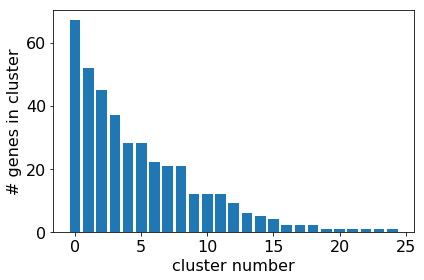

In [30]:
# SIZE DISTRIBUTION
# size of clusters
d_c_s = {}
for cl in set(l_cluster):
    d_c_s[cl] =  list(l_cluster).count(cl)

for cid,b in sorted(d_c_s.items(), key = lambda x: x[1], reverse = True)[:1]:
    print('largest cluster contains %s genes.' %b)

l_1 = [x for x in d_c_s.values() if x==1 ]    
print('there are %s clusters of size 1' %len(l_1))   
l_under5 = [x for x in d_c_s.values() if x<5 ]    
print('there are %s clusters of size smaller than 5' %len(l_under5))  
l_over10 = [x for x in d_c_s.values() if x>10 ]    
print('there are %s clusters bigger than 10 genes' %len(l_over10))     
    
plt.bar(range(len(d_c_s.keys()))[:50],sorted(d_c_s.values(),reverse = True)[:50])    
plt.ylabel('# genes in cluster',fontsize = 16)
plt.xlabel('cluster number',fontsize = 16)
ax = plt.gca()
tick_color = '#000000'
plt.tick_params(axis='both', which='major', colors=tick_color,labelsize=16)
ax.xaxis.label.set_color(tick_color)
ax.yaxis.label.set_color(tick_color)
plt.tight_layout()
plt.savefig(hist_pic) 

d_cluster_geneset = defaultdict(list)
node_idx = 0
for cluster_id in l_cluster:
    gene = d_idx_gene_feat[node_idx]
    node_idx += 1
    for cl in set(l_cluster):
        if cl == cluster_id:
            d_cluster_geneset[cl].append(gene)
            
ordered_d_cluster_geneset={}
for k in sorted(d_cluster_geneset, key=lambda k: len(d_cluster_geneset[k]), reverse=True):
    ordered_d_cluster_geneset[k]=d_cluster_geneset[k]
        





# CLUSTER OVERVIEW 

In [31]:
# LOOP THROUGH ALL CLUSTERS STARTING WITH THE LARGEST 
c = 0
l_cid = []
d_cluster_terms = {}
d_cluster_genes = {}
for cid, f in sorted(d_c_s.items(), key = lambda x: x[1], reverse = 1):
#     print(cid)
    l_cid.append(cid)

    # COLLECT ALL GENES FROM CLUSTER
    l_clustergenes = []
    c = 0
    for idx in l_cluster:
        if idx == cid:
            l_clustergenes.append(d_idx_gene_feat[c])
        c += 1
        
    d_cluster_genes[cid] = l_clustergenes
    ########################################
    # COLLECT ALL TERMS INCLUDED IN CLUSTER
    l_terms = []
    # Loop through genes
    c = 0
    for gene in l_clustergenes:
        termset = list(d_gene_terms_all[gene])
        l_terms += termset  
             
    d_cluster_terms[cid] = l_terms

    
# CLUSTER POSITION
    
d_cluster_xyz_var = {}
c = 0
for cid, f in sorted(d_c_s.items(), key = lambda x: x[1], reverse = 1):    
    l_x1 = []
    l_y1 = []
    for gene in d_cluster_genes[cid]:
        pos = posG[gene]
        l_x1.append(pos[0])
        l_y1.append(pos[1])

    d_cluster_xyz_var[cid] = (np.mean(l_x1),np.mean(l_y1),np.std(l_x1),np.std(l_y1))  
d_rank_cid = {}
rank = 1
allthedata=[]
tbl = PrettyTable(['rank','Cluster ID', '# genes', '# all terms', '# unique terms', 'position','spread', 'color'])
for cid,terms in d_cluster_terms.items():    
    d_rank_cid[rank] = cid
#     print(cid,d_clid_numgenes[cid],len(terms))
    if d_c_s[cid] > 1:
        x_pos = round(d_cluster_xyz_var[cid][0],2)
        y_pos = round(d_cluster_xyz_var[cid][1],2)
        del_x_pos = round(d_cluster_xyz_var[cid][2],2)
        del_y_pos = round(d_cluster_xyz_var[cid][3],2)
        allthedata.append({'rank':rank, 'Cluster ID':cid, '# genes':d_c_s[cid], '# all terms':len(terms), '# unique terms':len(set(terms)), 'position':[x_pos,y_pos], 'spread':[del_x_pos,del_y_pos],'color':d_cl_col[cid] })
        tbl.add_row([rank,cid,d_c_s[cid],len(terms),len(set(terms)),[x_pos,y_pos],[del_x_pos,del_y_pos],d_cl_col[cid]])
    rank += 1
# t.align['Number of...'] = 'l'
print(tbl)
tbl_dict= pd.DataFrame.from_dict(allthedata)
tbl_dict.set_index('Cluster ID')
len(tbl_dict)


tbl_dict.to_csv(summary_file, sep="\t")

+------+------------+---------+-------------+----------------+--------------+--------------+---------+
| rank | Cluster ID | # genes | # all terms | # unique terms |   position   |    spread    |  color  |
+------+------------+---------+-------------+----------------+--------------+--------------+---------+
|  1   |     14     |    67   |    16354    |      3001      | [0.85, 0.36] | [0.08, 0.11] | #ff0000 |
|  2   |     19     |    52   |    20974    |      4010      | [0.55, 0.77] | [0.14, 0.11] | #ff007a |
|  3   |     18     |    45   |    14952    |      2507      | [0.74, 0.72] | [0.1, 0.07]  | #ff3d00 |
|  4   |     12     |    37   |     6155    |      1696      | [0.6, 0.38]  | [0.08, 0.16] | #5100ff |
|  5   |     11     |    28   |     3170    |      752       | [0.1, 0.59]  | [0.06, 0.06] | #00a3ff |
|  6   |     13     |    28   |     3191    |      1059      | [0.67, 0.16] | [0.13, 0.11] | #ff00b7 |
|  7   |     17     |    22   |     5047    |      1489      | [0.36, 0.7

# Some labels 

In [32]:
#d_cid_label = {}
#cc = -1
#for cid, f in sorted(d_c_s.items(), key = lambda x: x[1], reverse = 1)[:20]:
##     print(cid)
#    labels = most_informative_label(G_DO_un,tree_tip,list(d_cluster_terms[cid]),5)
##         print(d_do_names[tf])
#    labelstr = ''
#    for label in labels:
##         print(label,d_do_names[label])
#        labelstr += d_do_names[label] + '\n'
#    d_cid_label[cid] = labelstr[:-1]
#
#    cc += 1

In [33]:
#d_cid_label

# MANUAL INSPECTIONS OF INDIVIDUAL CLUSTERS

In [34]:
for mykey, cid in d_rank_cid.items():
    cid = d_rank_cid[mykey]
    print(cid)
    terms = d_cluster_terms[cid]

    my_tbl = PrettyTable(['term name', 'frequency', 'plain annot','enrichment level (%)'])

    allthedata=[]
    for t in set(d_cluster_terms[cid]):
    #     print(t)
        freq = d_cluster_terms[cid].count(t)
        
        # number of genes in cluster, that are annotated directly to term
        plain_annot = len(set(d_term_gene[t]) & set(d_cluster_genes[cid]))
        # fraction of additional term enrichment:
        try:
            enrich_level = round(100.*freq/plain_annot-100.,1)
        except ZeroDivisionError:
            enrich_level =  -1.

        if enrich_level>0:
            my_tbl.add_row([d_names[t],freq,plain_annot,enrich_level])
            allthedata.append({'term name':d_names[t], 'frequency':freq, 'plain annot':plain_annot, 'enrichment level (%)':enrich_level })

    my_dict= pd.DataFrame.from_dict(allthedata)
    sf = StyleFrame(my_dict)
    sf.to_excel(writer, sheet_name='%s_rank_%s_clusterID' %(mykey,cid))
    
    
writer.save()

14
19
18
12
11
13
17
6
8
4
7
16
10
3
15
9
1
2
21
5
20
22
23
24
25


# Gene set from cluster X 

In [35]:
i = 1
# print(d_rank_cid[])
fp=open(clustergenes,'w')

print(len(tbl_dict))

while i in range(len(tbl_dict)+1):
    
    cluster_rank = i
    print('Geneset in cluster with rank %s (clusterID: %s)' %(cluster_rank,d_rank_cid[cluster_rank]))
    tbl = PrettyTable(['counter','entrezID', 'gene symbol'])
    fp.write('cluster_%s\t'%(d_rank_cid[cluster_rank]))
    #print(d_cluster_geneset[d_rank_cid[cluster_rank]])
    for gene in d_cluster_geneset[d_rank_cid[cluster_rank]]:
        if gene!='-':
            fp.write('%s\t'%(gene))
            try:
                mysym=d_ent_sym[gene]
            except:
                mysym=gene
            tbl.add_row([nn,gene, mysym])
        else:
            print(gene)
        nn +=1 
    fp.write('\n')
    tbl.align['entrezID'] = 'l'
    tbl.align['gene symbol'] = 'l'
    print(tbl)
    i+=1
fp.close()

19
Geneset in cluster with rank 1 (clusterID: 14)
+---------+----------+-------------+
| counter | entrezID | gene symbol |
+---------+----------+-------------+
|   393   | 1017     | CDK2        |
|   394   | 10346    | TRIM22      |
|   395   | 10488    | CREB3       |
|   396   | 10725    | NFAT5       |
|   397   | 10971    | YWHAQ       |
|   398   | 112399   | EGLN3       |
|   399   | 1385     | CREB1       |
|   400   | 1789     | DNMT3B      |
|   401   | 2023     | ENO1        |
|   402   | 2033     | EP300       |
|   403   | 2100     | ESR2        |
|   404   | 22938    | SNW1        |
|   405   | 23291    | FBXW11      |
|   406   | 25913    | POT1        |
|   407   | 2624     | GATA2       |
|   408   | 2908     | NR3C1       |
|   409   | 326      | AIRE        |
|   410   | 3394     | IRF8        |
|   411   | 340061   | TMEM173     |
|   412   | 3609     | ILF3        |
|   413   | 3725     | JUN         |
|   414   | 4171     | MCM2        |
|   415   | 4176     | MC

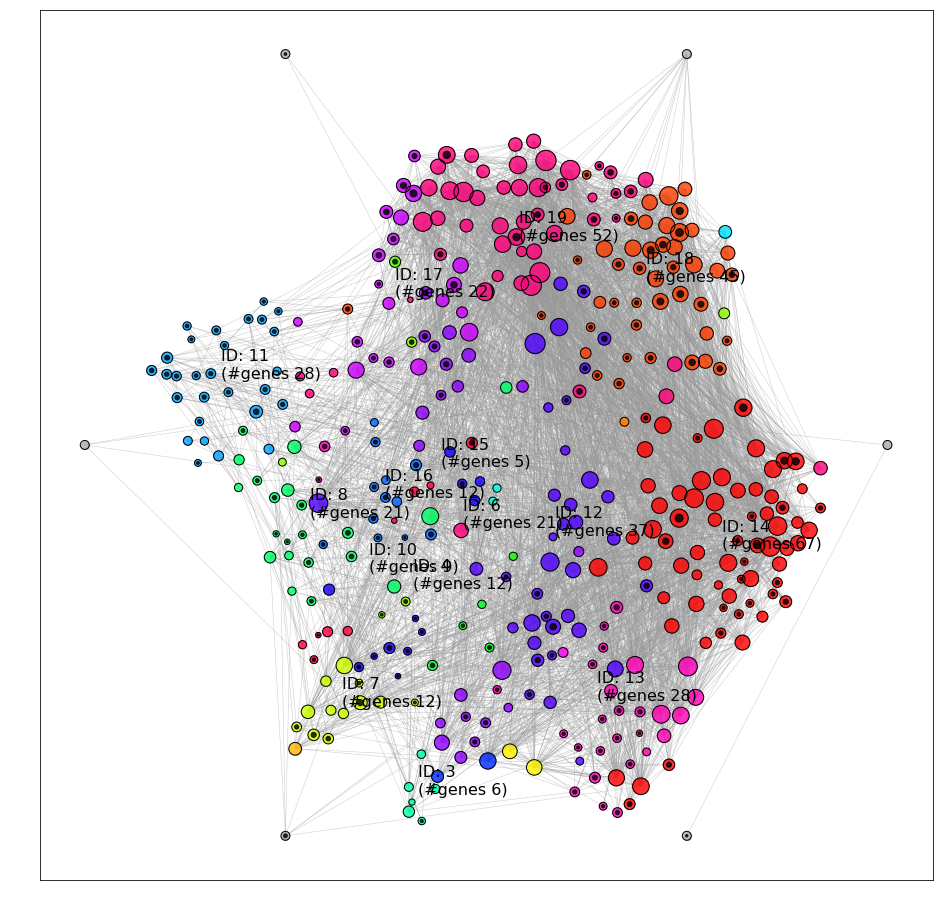

In [37]:
# label clusters in figure up to 
max_rk = 15
        
##################################################
# (UN-)COMMENT THIS BLOCK 
# IF YOU WANT TO (CHANGE) KEEP THE COLORS

# l_col = color_creator(len(set(l_cluster)))
# rd.shuffle(l_col)
# # l_col = cemm_pal(len(set(l_cluster)))
# d_cl_col = {}
# c = 0
# for cl,size in sorted(d_c_s.items(), key = lambda x: x[1], reverse = True):
#     if cl == 0:
#         d_cl_col[cl] = '#ababab'
#     else:
#         d_cl_col[cl] = l_col[c]
#     c +=1

##################################################

# # NORMALIZE COORDINATES
# l_x = X_tsne2D[:,0]
# l_y = X_tsne2D[:,1]

# NORMALIZE COORDINATES
l_x = umap_pos[:,0]
l_y = umap_pos[:,1]

x_min = min(l_x)
x_max = max(l_x)
y_min = min(l_y)
y_max = max(l_x)

l_xn = [(x-x_min)/(x_max-x_min) for x in l_x]
l_yn = [(y-y_min)/(y_max-y_min) for y in l_y]


posG = {}
for gene in d_gene_terms_all.keys():
    idx = d_gene_idx_feat[gene]
    posG[gene] = (l_xn[idx],l_yn[idx])

# position for nodes without any functional features
# for node in nodes_no_feat:
#     posG[node] = (0.,0.)

# CREATE HALO OUT OF NON-ANNOTATED GENES:
# SET OF NON-ANNOTATED GENES:
nodes_no_feat = set(G.nodes())-set(d_gene_terms_all.keys())
# divide 360 by this number to get angle increments
deg_i = 2.*np.pi / len(nodes_no_feat)
l_xno = []
l_yno = []
x0 = min(l_xn)+.5
y0 = min(l_yn)+.5
if (max(l_xn)-min(l_xn)) > (max(l_yn)-min(l_yn)):
    radius = .6*(max(l_xn)-min(l_xn))
else:
    radius = .6*(max(l_yn)-min(l_yn))

for g in range(len(nodes_no_feat)):
    x = radius*np.cos(g*deg_i) + x0
    y = radius*np.sin(g*deg_i) + y0
    l_xno.append(x)
    l_yno.append(y)    
    
scalef = 15
x = 20
power = .7
# ring_frac = np.sqrt((x-1.)/x)
ring_frac = (x-1.)/x

n_none = 0
for node in nodes_no_feat:
    posG[node] = (l_xno[n_none],l_yno[n_none])
    n_none += 1
    
    
plt.figure(figsize=(16,16))


plt.scatter(l_xno,l_yno,s=70,c = '#ababab',label = 'none:',zorder=2,alpha=.8)
plt.scatter(l_xno,l_yno,s=80,facecolors='none',edgecolors='k',zorder=2)

edgewidth = .5#[ .2*d['weight'] for (u,v,d) in G_result.edges(data=True)]

nx.draw_networkx_edges(G, pos=posG, width=edgewidth,edge_color='#999999',alpha=.5)

scalef = 15
x = 20
power = .7
# ring_frac = np.sqrt((x-1.)/x)
ring_frac = (x-1.)/x


for cluster, geneset in d_cluster_geneset.items():
    color = d_cl_col[cluster]
    l_x = []
    l_y = []
    l_size_outer = []
    l_size_inner = []
    for node in G.nodes():
        if node in geneset:
            k = nx.degree(G,node)
            R = scalef*(1+k**power)
            r = ring_frac * R
            l_size_outer.append(R)
            l_size_inner.append(r)
            l_x.append(posG[node][0])
            l_y.append(posG[node][1])


    plt.scatter(l_x,l_y,s=l_size_inner,c = color,label = '%s' %cluster,zorder=2,alpha=.8)
    plt.scatter(l_x,l_y,s=l_size_outer,facecolors='none',edgecolors='k',zorder=2)

l_x = []
l_y = []
l_size_outer = []
l_size_inner = []
for node in G.nodes():
    if node in mono_all:

        k = nx.degree(G,node)
        R = scalef*(1+k**power)
        r = ring_frac * R
        l_size_outer.append(R)
        l_size_inner.append(.2*r)
        l_x.append(posG[node][0])
        l_y.append(posG[node][1])


plt.scatter(l_x,l_y,s=l_size_inner,c = 'k',label = 'seed genes',zorder=2,alpha=.8)

# LABEL FOR CLUSTERS (ONLY FOR CLUSTYERS WITH GIVEN MIN NUMBER OF GENES)
l_cidlbls = list(d_rank_cid.values())[:max_rk]
for cid, xy in d_cluster_xyz_var.items():
    if cid in l_cidlbls:
        plt.text(xy[0],xy[1],'ID: %s\n(#genes %s)' %(cid,d_c_s[cid]),fontsize = 16)
    
ax = plt.gca()

# ax.set_xticks(range(len(l_r)))    
# ax.set_xticklabels(x_ticks, rotation=90) #set the labels and rotate them 90 deg.
tick_color = 'w'
plt.tick_params(axis='both', which='major', colors=tick_color,labelsize=16)
ax.xaxis.label.set_color(tick_color)
ax.yaxis.label.set_color(tick_color)  


plt.savefig(picture_with_labels)

    
    
    

